In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
df = pd.read_excel('data_readed.xlsx')
df.head()

,row,col,datetime,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,SLHF,SLOR,SSHF,TCLW,TCW,TCWV,U250,U850,V250,V850
0,0,104,2020-10-01 00:00:00,0.0,197.25,61.953484,-113.054688,-0.000017,0.676296,36.621414,...,-59037,0.023543,-27549,0.373413,59.393524,59.004852,-5.800369,-0.907883,-0.157303,3.689789
1,0,104,2020-10-01 01:00:00,0.0,138.50,9999.000000,-128.285156,-0.000038,0.676296,36.078514,...,-203202,0.023543,-64968,0.274780,59.516571,59.215790,-5.511688,-0.485977,-0.572311,3.517319
2,0,104,2020-10-01 02:00:00,0.0,102.00,9999.000000,-120.671875,-0.000055,0.676296,35.410492,...,-376145,0.023543,-81566,0.194763,59.715759,59.483337,-4.963364,-0.448380,-1.284912,3.182495
3,0,104,2020-10-01 03:00:00,0.0,160.75,9999.000000,-169.191406,-0.000064,0.676296,34.843140,...,-609080,0.023543,-101141,0.187439,60.249374,60.005234,-4.379272,-0.892761,-2.056778,2.465332
4,0,104,2020-10-01 04:00:00,0.0,204.50,213.468903,-304.347656,-0.000112,0.676296,34.893394,...,-654851,0.023543,-97831,0.104156,60.974991,60.775604,-3.959961,-1.550842,-2.280151,1.559830


In [ ]:
for col in ['datetime', 'row', 'col']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

df.fillna(0, inplace=True)

df.head()


,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,PEV,R250,R500,...,SLHF,SLOR,SSHF,TCLW,TCW,TCWV,U250,U850,V250,V850
0,0.0,197.25,61.953484,-113.054688,-0.000017,0.676296,36.621414,-0.000010,68.889862,80.423920,...,-59037,0.023543,-27549,0.373413,59.393524,59.004852,-5.800369,-0.907883,-0.157303,3.689789
1,0.0,138.50,9999.000000,-128.285156,-0.000038,0.676296,36.078514,-0.000055,65.620728,82.148590,...,-203202,0.023543,-64968,0.274780,59.516571,59.215790,-5.511688,-0.485977,-0.572311,3.517319
2,0.0,102.00,9999.000000,-120.671875,-0.000055,0.676296,35.410492,-0.000118,63.502029,84.858505,...,-376145,0.023543,-81566,0.194763,59.715759,59.483337,-4.963364,-0.448380,-1.284912,3.182495
3,0.0,160.75,9999.000000,-169.191406,-0.000064,0.676296,34.843140,-0.000214,64.548126,88.440002,...,-609080,0.023543,-101141,0.187439,60.249374,60.005234,-4.379272,-0.892761,-2.056778,2.465332
4,0.0,204.50,213.468903,-304.347656,-0.000112,0.676296,34.893394,-0.000241,68.587189,89.714478,...,-654851,0.023543,-97831,0.104156,60.974991,60.775604,-3.959961,-1.550842,-2.280151,1.559830


In [ ]:
target_column = df.columns[-1]
corr = df.corr()
abs_corr = corr[target_column].abs()

top_10_features = abs_corr.drop(target_column).sort_values(ascending=False).index[:10]
print("Top 10 features:", list(top_10_features))

features = df[top_10_features]
target = df[target_column]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

print("Features shape:", X_scaled.shape)


Top 10 features: ['U850', 'U250', 'CIN', 'CAPE', 'KX', 'R500', 'TCLW', 'V250', 'SSHF', 'EWSS']
Features shape: (657681, 10)


In [6]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


X_seq shape: (657671, 10, 10)
y_seq shape: (657671, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 526136
Testing samples: 131535


In [8]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,826 (77.45 KB)

 Trainable params: 19,826 (77.45 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - loss: 0.0184 - val_loss: 0.0095
Epoch 2/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 106s 7ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 3/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 106s 7ms/step - loss: 0.0059 - val_loss: 0.0082
Epoch 4/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 109s 7ms/step - loss: 0.0050 - val_loss: 0.0075
Epoch 5/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 109s 7ms/step - loss: 0.0044 - val_loss: 0.0074
Epoch 6/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 109s 7ms/step - loss: 0.0040 - val_loss: 0.0069
Epoch 7/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - loss: 0.0037 - val_loss: 0.0075
Epoch 8/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 107s 7ms/step - loss: 0.0035 - val_loss: 0.0074
Epoch 9/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 109s 7ms/step - loss: 0.0034 - val_loss: 0.0071
Epoch 10/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 106s 7ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 11/100
14798/14798 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - loss: 0

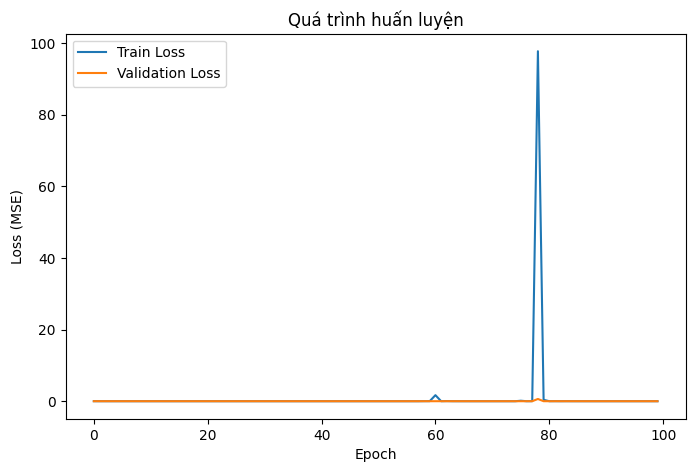

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Quá trình huấn luyện')
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)
print("Dự đoán:", y_pred_inv[:5].flatten())
print("Thật:", y_test_inv[:5].flatten())


4111/4111 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
Dự đoán: [1.0180994  0.99419945 0.84260017 0.7867419  0.71068025]
Thật: [1.19947815 1.50250244 1.56809998 1.36334229 1.43013   ]


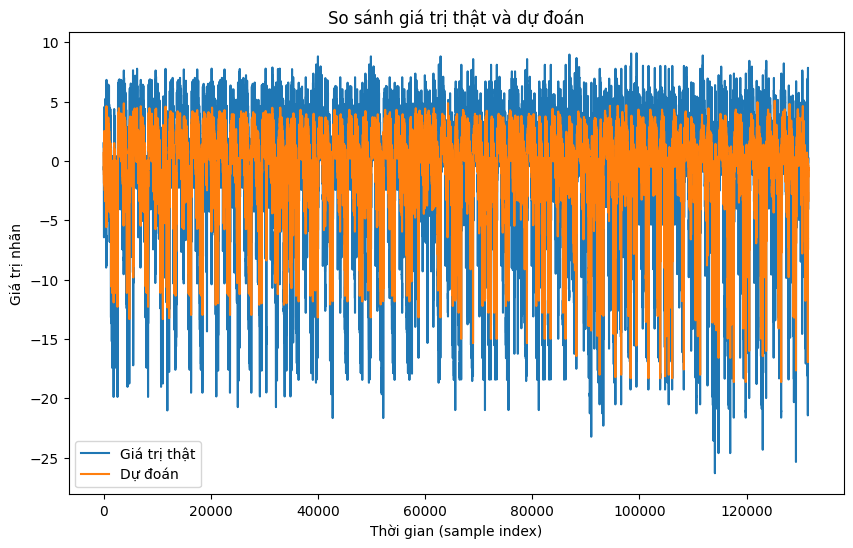

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Giá trị thật')
plt.plot(y_pred_inv, label='Dự đoán')
plt.xlabel('Thời gian (sample index)')
plt.ylabel('Giá trị nhãn')
plt.title('So sánh giá trị thật và dự đoán')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score
import numpy as np

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đưa dữ liệu về giá trị ban đầu
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Tính các chỉ số đánh giá
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
med_ae = median_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
explained_var = explained_variance_score(y_test_inv, y_pred_inv)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Median Absolute Error:", med_ae)
print("R² Score:", r2)
print("Explained Variance Score:", explained_var)


4111/4111 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Mean Squared Error (MSE): 19.842429014734247
Root Mean Squared Error (RMSE): 4.454484146872031
Mean Absolute Error (MAE): 3.1421037194392385
Median Absolute Error: 2.0203057527542105
R² Score: 0.46440349649926604
Explained Variance Score: 0.5216999497160578
